In [20]:
import os
from datetime import datetime
import re
import random
from collections import Counter
import glob

from sklearn.base import defaultdict
import pandas as pd
from matplotlib import pyplot as plt, font_manager, rcParams

# Plot font configuration
FONT_PATH = "./fonts/Noto_Sans_Javanese/static/NotoSansJavanese-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams["font.family"] = font_manager.FontProperties(fname=FONT_PATH).get_name()


In [21]:
TOTAL_CSV = 8
ROWS_PER_CSV = 50
TOTAL_SAMPLE = TOTAL_CSV * ROWS_PER_CSV

CONFIG = {
    "min_word": 2,
    "max_word": 6,
}

BASE_DIR = f"./data/word_nglegena_handwritten_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(BASE_DIR, exist_ok=True)


NGLEGENA = [
    ("ꦲ","ha"), ("ꦤ","na"), ("ꦕ","ca"), ("ꦫ","ra"), ("ꦏ","ka"),
    ("ꦢ","da"), ("ꦠ","ta"), ("ꦱ","sa"), ("ꦮ","wa"), ("ꦭ","la"),
    ("ꦥ","pa"), ("ꦝ","dha"), ("ꦗ","ja"), ("ꦪ","ya"), ("ꦚ","nya"),
    ("ꦩ","ma"), ("ꦒ","ga"), ("ꦧ","ba"), ("ꦛ","tha"), ("ꦔ","nga"),
]


In [ ]:
def generate_word(cfg):
    length = random.randint(cfg["min_word"], cfg["max_word"])
    jawa, latin = "", ""

    for _ in range(length):
        aks, lat = random.choice(NGLEGENA)
        jawa += aks
        latin += lat

    return jawa, latin, length


def generate_dataset(total, cfg, coverage):
    rows = []
    seen_words = set()
    idx = 0

    while len(rows) < total:
        jawa, latin, length = generate_word(cfg)

        if jawa in seen_words:
            continue
        seen_words.add(jawa)

        coverage["word"][length] += 1
        for aks in jawa:
            coverage["aksara"][aks] += 1

        rows.append({
            "image": f"h_img_{idx:05d}.png",
            "transcription": jawa,
            "transliteration": latin,
            "length": length,
        })
        idx += 1

    return pd.DataFrame(rows)



coverage = {
    "aksara": Counter({aks: 0 for aks, _ in NGLEGENA}),
    "word": Counter()
}
df = generate_dataset(TOTAL_SAMPLE, CONFIG, coverage)
print(f"Total generated samples: {len(df)}")



# Split & shuffle into multiple CSV files
assert len(df) == TOTAL_SAMPLE
groups = defaultdict(list)

for _, row in df.iterrows():
    groups[row["length"]].append(row)

for length in groups:
    random.shuffle(groups[length])

ordered_rows = []
for length in sorted(groups.keys()):
    ordered_rows.extend(groups[length])

random.shuffle(ordered_rows)

for i in range(TOTAL_CSV):
    start = i * ROWS_PER_CSV
    end = start + ROWS_PER_CSV

    bucket = ordered_rows[start:end]
    assert len(bucket) == ROWS_PER_CSV

    csv_df = pd.DataFrame(bucket)
    csv_path = os.path.join(BASE_DIR, f"label_{i+1}.csv")
    csv_df.to_csv(csv_path, index=False)

    print(f"Saved {len(csv_df)} samples to {csv_path}")


Total generated samples: 400
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_1.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_2.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_3.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_4.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_5.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_6.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_7.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_151120\label_8.csv


In [23]:
ALLOWED_CHARS = set([aks for aks, _ in NGLEGENA])
REQUIRED_COLS = {"image", "transcription", "transliteration", "length"}
ROWS_PER_CSV = 50


def validate_csv(csv_path):
    print(f"\nValidating file: {csv_path}")
    print("-" * 50)

    df = pd.read_csv(csv_path)

    print(f"Jumlah baris               : {len(df)}")
    if len(df) != ROWS_PER_CSV:
        print("Jumlah baris tidak sesuai")

    missing_cols = REQUIRED_COLS - set(df.columns)
    if missing_cols:
        print(f"Kolom wajib hilang       : {missing_cols}")
    else:
        print("Skema kolom              : valid")

    null_rows = df[df.isnull().any(axis=1)]
    print(f"Baris dengan nilai kosong  : {len(null_rows)}")

    dup_pair = df[df.duplicated(["image", "transcription"], keep="first")]
    dup_semantic = df[df.duplicated(["transcription", "transliteration"], keep="first")]

    print(f"Duplikat image–label       : {len(dup_pair)}")
    print(f"Duplikat semantic label    : {len(dup_semantic)}")

    length_mismatch = df[df["transcription"].str.len() != df["length"]]
    print(f"Length mismatch            : {len(length_mismatch)}")

    oov_counter = Counter()
    oov_rows = []

    for idx, text in df["transcription"].items():
        oov = [ch for ch in text if ch not in ALLOWED_CHARS]
        if oov:
            oov_rows.append(idx)
            oov_counter.update(oov)

    print(f"Baris mengandung OOV       : {len(oov_rows)}")
    if oov_counter:
        print("OOV aksara:")
        for ch, c in oov_counter.items():
            print(f"  '{ch}' : {c}x")

    ctrl_rows = df[df["transcription"].apply(
        lambda x: bool(re.search(r"[\u0000-\u001F\u007F]", x))
    )]
    print(f"Karakter kontrol tersembunyi : {len(ctrl_rows)}")

    problem_idx = set()
    problem_idx.update(null_rows.index)
    problem_idx.update(dup_pair.index)
    problem_idx.update(dup_semantic.index)
    problem_idx.update(length_mismatch.index)
    problem_idx.update(oov_rows)
    problem_idx.update(ctrl_rows.index)

    print(f"Total baris bermasalah     : {len(problem_idx)}")
    print(f"Total baris valid          : {len(df) - len(problem_idx)}")



csv_files = sorted(glob.glob(os.path.join(BASE_DIR, "label_*.csv")))
for csv_path in csv_files:
    validate_csv(csv_path)


Validating file: ./data/word_nglegena_handwritten_20260109_151120\label_1.csv
--------------------------------------------------
Jumlah baris               : 50
Skema kolom              : valid
Baris dengan nilai kosong  : 0
Duplikat image–label       : 0
Duplikat semantic label    : 0
Length mismatch            : 0
Baris mengandung OOV       : 0
Karakter kontrol tersembunyi : 0
Total baris bermasalah     : 0
Total baris valid          : 50

Validating file: ./data/word_nglegena_handwritten_20260109_151120\label_2.csv
--------------------------------------------------
Jumlah baris               : 50
Skema kolom              : valid
Baris dengan nilai kosong  : 0
Duplikat image–label       : 0
Duplikat semantic label    : 0
Length mismatch            : 0
Baris mengandung OOV       : 0
Karakter kontrol tersembunyi : 0
Total baris bermasalah     : 0
Total baris valid          : 50

Validating file: ./data/word_nglegena_handwritten_20260109_151120\label_3.csv
-----------------------------

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_1.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.74

DISTRIBUSI PANJANG KATA
 2 aksara |    13 baris |  26.00%
 3 aksara |     9 baris |  18.00%
 4 aksara |    13 baris |  26.00%
 5 aksara |     8 baris |  16.00%
 6 aksara |     7 baris |  14.00%


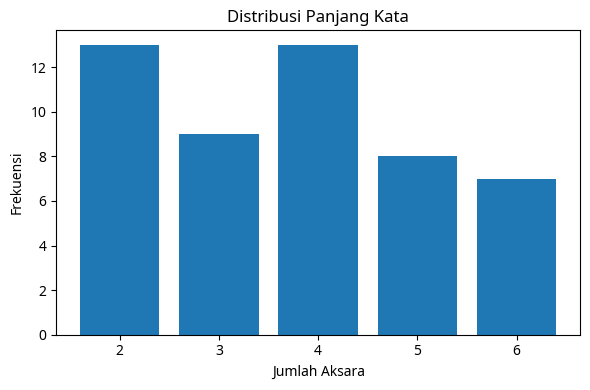

DISTRIBUSI AKSARA
  ꦲ (ha ) |      8 |   4.28%
  ꦤ (na ) |      9 |   4.81%
  ꦕ (ca ) |      5 |   2.67%
  ꦫ (ra ) |      3 |   1.60%
  ꦏ (ka ) |      9 |   4.81%
  ꦢ (da ) |      5 |   2.67%
  ꦠ (ta ) |     15 |   8.02%
  ꦱ (sa ) |     13 |   6.95%
  ꦮ (wa ) |      8 |   4.28%
  ꦭ (la ) |      8 |   4.28%
  ꦥ (pa ) |      6 |   3.21%
  ꦝ (dha) |     13 |   6.95%
  ꦗ (ja ) |     12 |   6.42%
  ꦪ (ya ) |      9 |   4.81%
  ꦚ (nya) |      8 |   4.28%
  ꦩ (ma ) |     14 |   7.49%
  ꦒ (ga ) |     10 |   5.35%
  ꦧ (ba ) |      8 |   4.28%
  ꦛ (tha) |     14 |   7.49%
  ꦔ (nga) |     10 |   5.35%

Total aksara: 187


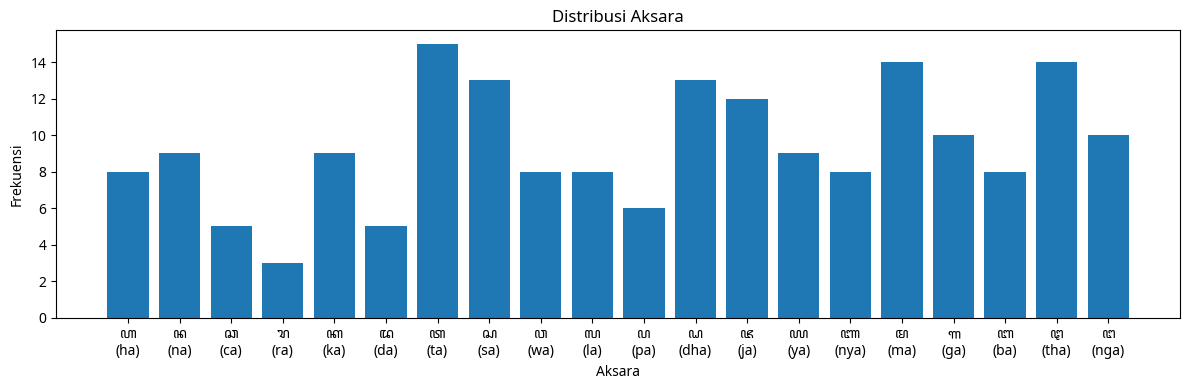

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_2.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.02

DISTRIBUSI PANJANG KATA
 2 aksara |    11 baris |  22.00%
 3 aksara |     8 baris |  16.00%
 4 aksara |     9 baris |  18.00%
 5 aksara |    13 baris |  26.00%
 6 aksara |     9 baris |  18.00%


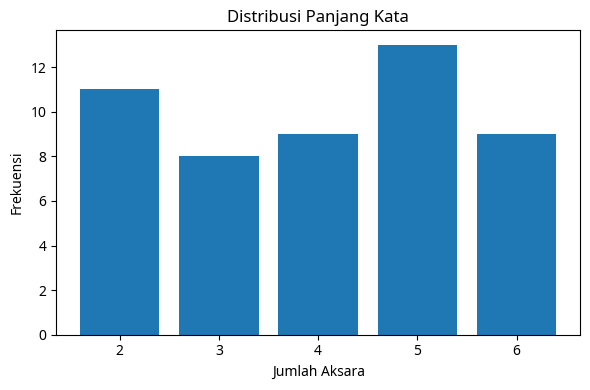

DISTRIBUSI AKSARA
  ꦲ (ha ) |     14 |   6.97%
  ꦤ (na ) |     10 |   4.98%
  ꦕ (ca ) |      9 |   4.48%
  ꦫ (ra ) |     13 |   6.47%
  ꦏ (ka ) |     10 |   4.98%
  ꦢ (da ) |     14 |   6.97%
  ꦠ (ta ) |     14 |   6.97%
  ꦱ (sa ) |     11 |   5.47%
  ꦮ (wa ) |     15 |   7.46%
  ꦭ (la ) |      7 |   3.48%
  ꦥ (pa ) |     11 |   5.47%
  ꦝ (dha) |      4 |   1.99%
  ꦗ (ja ) |      7 |   3.48%
  ꦪ (ya ) |      9 |   4.48%
  ꦚ (nya) |      6 |   2.99%
  ꦩ (ma ) |     10 |   4.98%
  ꦒ (ga ) |     10 |   4.98%
  ꦧ (ba ) |     11 |   5.47%
  ꦛ (tha) |      8 |   3.98%
  ꦔ (nga) |      8 |   3.98%

Total aksara: 201


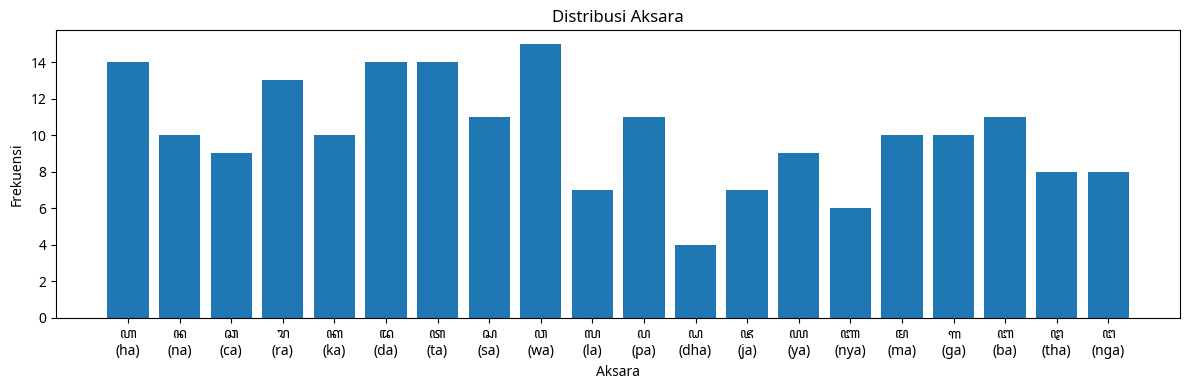

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_3.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.12

DISTRIBUSI PANJANG KATA
 2 aksara |     8 baris |  16.00%
 3 aksara |    10 baris |  20.00%
 4 aksara |     8 baris |  16.00%
 5 aksara |    16 baris |  32.00%
 6 aksara |     8 baris |  16.00%


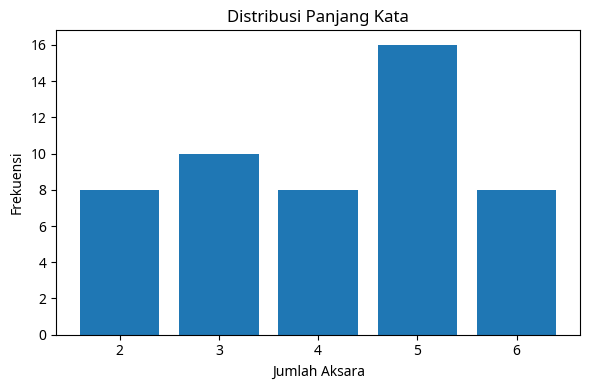

DISTRIBUSI AKSARA
  ꦲ (ha ) |     14 |   6.80%
  ꦤ (na ) |      6 |   2.91%
  ꦕ (ca ) |      9 |   4.37%
  ꦫ (ra ) |     14 |   6.80%
  ꦏ (ka ) |      8 |   3.88%
  ꦢ (da ) |     10 |   4.85%
  ꦠ (ta ) |     17 |   8.25%
  ꦱ (sa ) |     10 |   4.85%
  ꦮ (wa ) |     10 |   4.85%
  ꦭ (la ) |     10 |   4.85%
  ꦥ (pa ) |     10 |   4.85%
  ꦝ (dha) |      5 |   2.43%
  ꦗ (ja ) |     11 |   5.34%
  ꦪ (ya ) |     11 |   5.34%
  ꦚ (nya) |      8 |   3.88%
  ꦩ (ma ) |     12 |   5.83%
  ꦒ (ga ) |     10 |   4.85%
  ꦧ (ba ) |     13 |   6.31%
  ꦛ (tha) |      7 |   3.40%
  ꦔ (nga) |     11 |   5.34%

Total aksara: 206


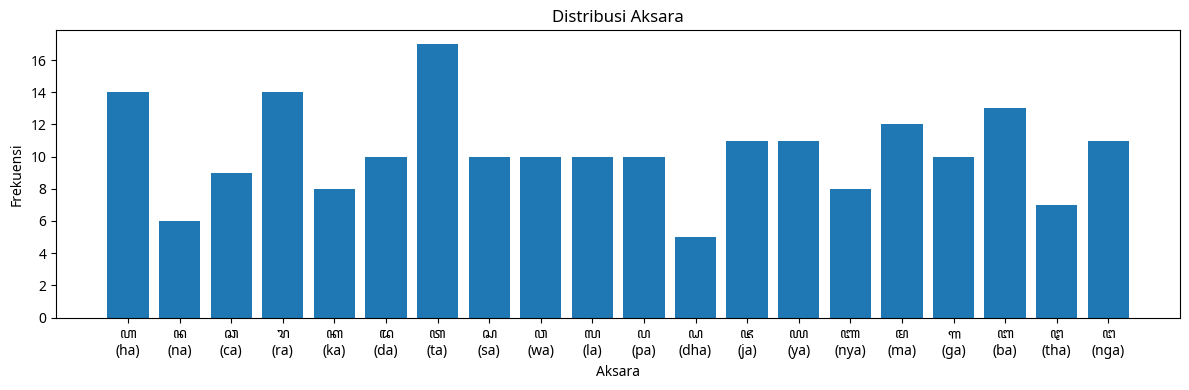

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_4.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.90

DISTRIBUSI PANJANG KATA
 2 aksara |     5 baris |  10.00%
 3 aksara |    17 baris |  34.00%
 4 aksara |    12 baris |  24.00%
 5 aksara |    10 baris |  20.00%
 6 aksara |     6 baris |  12.00%


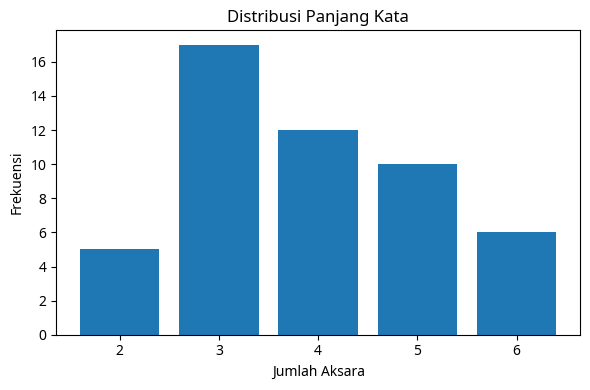

DISTRIBUSI AKSARA
  ꦲ (ha ) |      6 |   3.08%
  ꦤ (na ) |     13 |   6.67%
  ꦕ (ca ) |      7 |   3.59%
  ꦫ (ra ) |     13 |   6.67%
  ꦏ (ka ) |     14 |   7.18%
  ꦢ (da ) |     10 |   5.13%
  ꦠ (ta ) |     11 |   5.64%
  ꦱ (sa ) |     10 |   5.13%
  ꦮ (wa ) |     14 |   7.18%
  ꦭ (la ) |      9 |   4.62%
  ꦥ (pa ) |      7 |   3.59%
  ꦝ (dha) |      9 |   4.62%
  ꦗ (ja ) |      4 |   2.05%
  ꦪ (ya ) |      4 |   2.05%
  ꦚ (nya) |      9 |   4.62%
  ꦩ (ma ) |     10 |   5.13%
  ꦒ (ga ) |     17 |   8.72%
  ꦧ (ba ) |      7 |   3.59%
  ꦛ (tha) |      7 |   3.59%
  ꦔ (nga) |     14 |   7.18%

Total aksara: 195


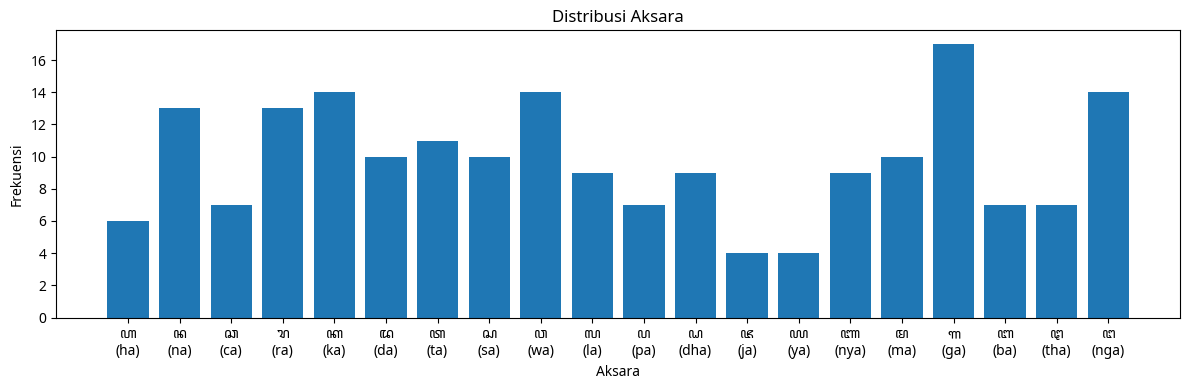

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_5.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.90

DISTRIBUSI PANJANG KATA
 2 aksara |    10 baris |  20.00%
 3 aksara |    12 baris |  24.00%
 4 aksara |     8 baris |  16.00%
 5 aksara |    13 baris |  26.00%
 6 aksara |     7 baris |  14.00%


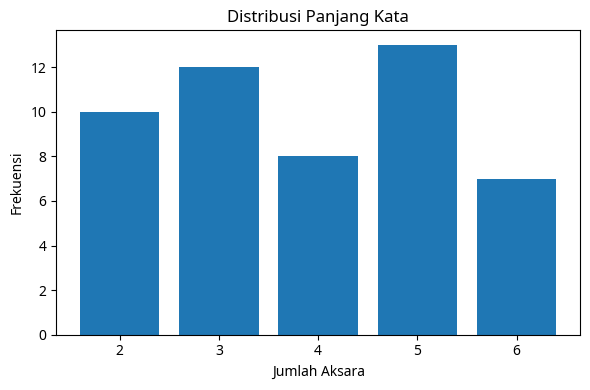

DISTRIBUSI AKSARA
  ꦲ (ha ) |     12 |   6.15%
  ꦤ (na ) |     13 |   6.67%
  ꦕ (ca ) |      8 |   4.10%
  ꦫ (ra ) |      4 |   2.05%
  ꦏ (ka ) |      9 |   4.62%
  ꦢ (da ) |      6 |   3.08%
  ꦠ (ta ) |     14 |   7.18%
  ꦱ (sa ) |     11 |   5.64%
  ꦮ (wa ) |     16 |   8.21%
  ꦭ (la ) |     10 |   5.13%
  ꦥ (pa ) |     12 |   6.15%
  ꦝ (dha) |     10 |   5.13%
  ꦗ (ja ) |      9 |   4.62%
  ꦪ (ya ) |     10 |   5.13%
  ꦚ (nya) |      7 |   3.59%
  ꦩ (ma ) |      7 |   3.59%
  ꦒ (ga ) |      6 |   3.08%
  ꦧ (ba ) |      7 |   3.59%
  ꦛ (tha) |     12 |   6.15%
  ꦔ (nga) |     12 |   6.15%

Total aksara: 195


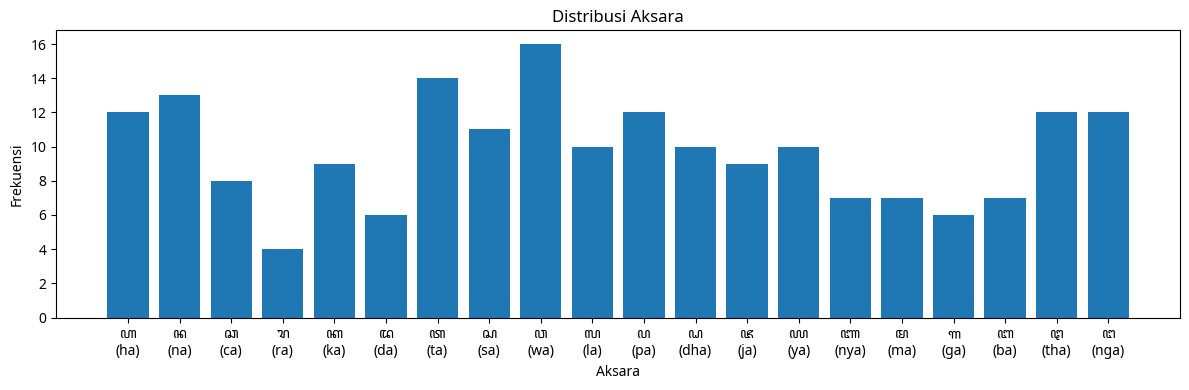

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_6.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.08

DISTRIBUSI PANJANG KATA
 2 aksara |     7 baris |  14.00%
 3 aksara |    11 baris |  22.00%
 4 aksara |    12 baris |  24.00%
 5 aksara |    11 baris |  22.00%
 6 aksara |     9 baris |  18.00%


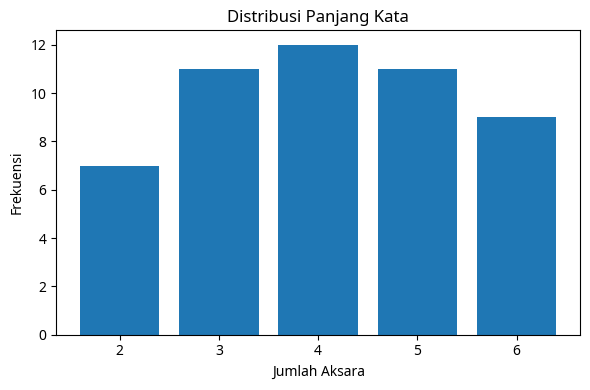

DISTRIBUSI AKSARA
  ꦲ (ha ) |     10 |   4.90%
  ꦤ (na ) |     13 |   6.37%
  ꦕ (ca ) |     10 |   4.90%
  ꦫ (ra ) |     11 |   5.39%
  ꦏ (ka ) |     13 |   6.37%
  ꦢ (da ) |     11 |   5.39%
  ꦠ (ta ) |      7 |   3.43%
  ꦱ (sa ) |      5 |   2.45%
  ꦮ (wa ) |     11 |   5.39%
  ꦭ (la ) |      9 |   4.41%
  ꦥ (pa ) |     13 |   6.37%
  ꦝ (dha) |      9 |   4.41%
  ꦗ (ja ) |      7 |   3.43%
  ꦪ (ya ) |     10 |   4.90%
  ꦚ (nya) |     15 |   7.35%
  ꦩ (ma ) |      7 |   3.43%
  ꦒ (ga ) |      6 |   2.94%
  ꦧ (ba ) |     10 |   4.90%
  ꦛ (tha) |     13 |   6.37%
  ꦔ (nga) |     14 |   6.86%

Total aksara: 204


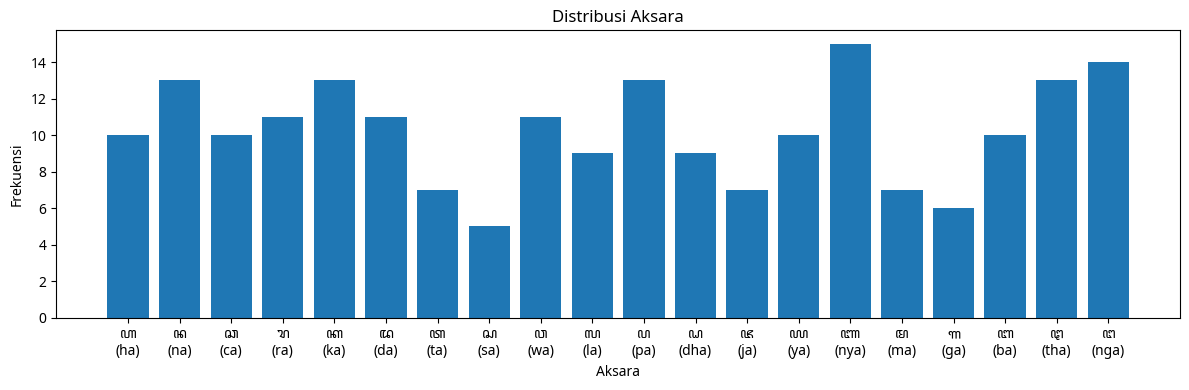

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_7.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.24

DISTRIBUSI PANJANG KATA
 2 aksara |     9 baris |  18.00%
 3 aksara |    10 baris |  20.00%
 4 aksara |     7 baris |  14.00%
 5 aksara |     8 baris |  16.00%
 6 aksara |    16 baris |  32.00%


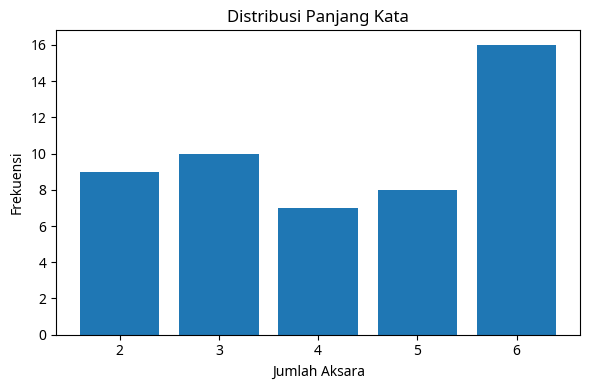

DISTRIBUSI AKSARA
  ꦲ (ha ) |     12 |   5.66%
  ꦤ (na ) |      8 |   3.77%
  ꦕ (ca ) |     10 |   4.72%
  ꦫ (ra ) |      8 |   3.77%
  ꦏ (ka ) |     11 |   5.19%
  ꦢ (da ) |      9 |   4.25%
  ꦠ (ta ) |      8 |   3.77%
  ꦱ (sa ) |     13 |   6.13%
  ꦮ (wa ) |     12 |   5.66%
  ꦭ (la ) |     14 |   6.60%
  ꦥ (pa ) |     14 |   6.60%
  ꦝ (dha) |     12 |   5.66%
  ꦗ (ja ) |      9 |   4.25%
  ꦪ (ya ) |      8 |   3.77%
  ꦚ (nya) |     12 |   5.66%
  ꦩ (ma ) |     13 |   6.13%
  ꦒ (ga ) |      6 |   2.83%
  ꦧ (ba ) |      9 |   4.25%
  ꦛ (tha) |     14 |   6.60%
  ꦔ (nga) |     10 |   4.72%

Total aksara: 212


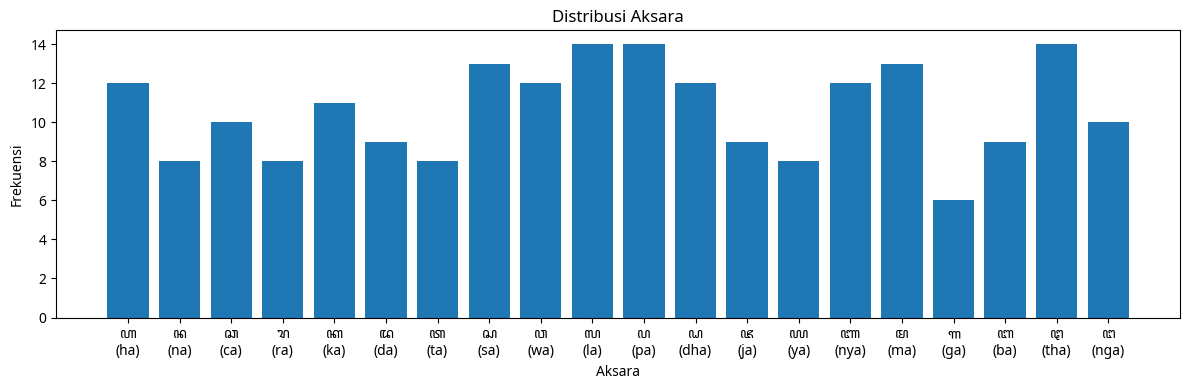

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_151120\label_8.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.14

DISTRIBUSI PANJANG KATA
 2 aksara |     9 baris |  18.00%
 3 aksara |     8 baris |  16.00%
 4 aksara |    11 baris |  22.00%
 5 aksara |    11 baris |  22.00%
 6 aksara |    11 baris |  22.00%


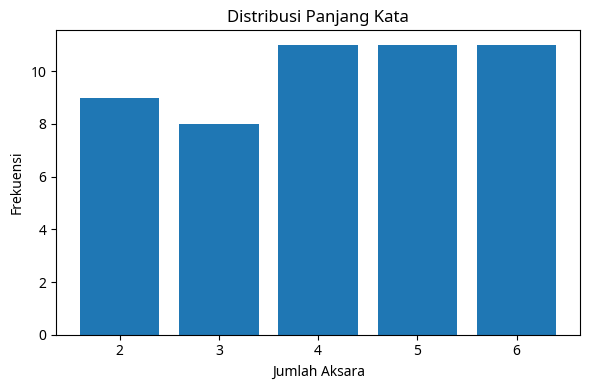

DISTRIBUSI AKSARA
  ꦲ (ha ) |     13 |   6.28%
  ꦤ (na ) |     11 |   5.31%
  ꦕ (ca ) |      6 |   2.90%
  ꦫ (ra ) |      7 |   3.38%
  ꦏ (ka ) |     13 |   6.28%
  ꦢ (da ) |     10 |   4.83%
  ꦠ (ta ) |     14 |   6.76%
  ꦱ (sa ) |     11 |   5.31%
  ꦮ (wa ) |      6 |   2.90%
  ꦭ (la ) |     14 |   6.76%
  ꦥ (pa ) |      9 |   4.35%
  ꦝ (dha) |     12 |   5.80%
  ꦗ (ja ) |      7 |   3.38%
  ꦪ (ya ) |     11 |   5.31%
  ꦚ (nya) |      6 |   2.90%
  ꦩ (ma ) |     13 |   6.28%
  ꦒ (ga ) |      9 |   4.35%
  ꦧ (ba ) |     14 |   6.76%
  ꦛ (tha) |      9 |   4.35%
  ꦔ (nga) |     12 |   5.80%

Total aksara: 207


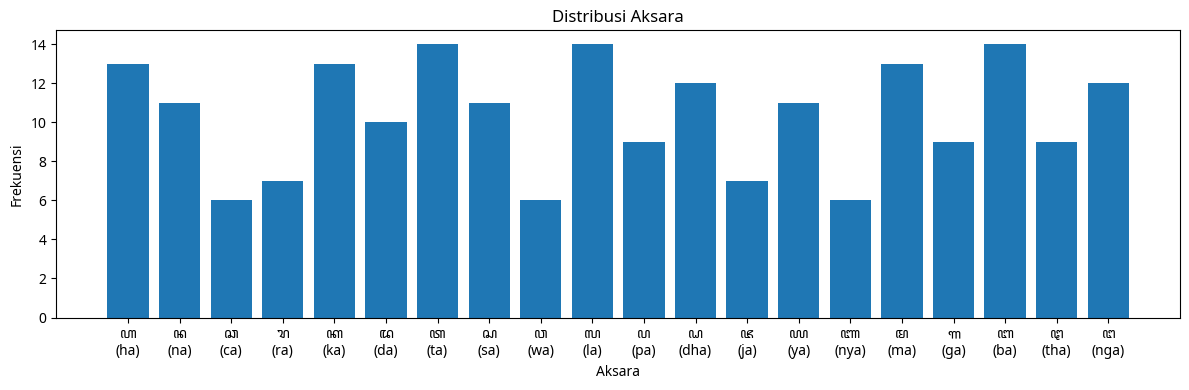

In [25]:
def plot_bar(x, y, title, xlabel, ylabel, figsize):
    plt.figure(figsize=figsize)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def analyze_csv(
    csv_path,
    nglegena,
    show_plot=True,
):
    df = pd.read_csv(csv_path)
    latin_map = {aks: lat for aks, lat in nglegena}

    # ==============================
    # DATA SUMMARY
    # ==============================
    print("=" * 40)
    print(f"RINGKASAN DATA : {csv_path}")
    print("=" * 40)

    print(
        f"Total kata            : {len(df)}\n"
        f"Min panjang kata      : {df['length'].min()}\n"
        f"Max panjang kata      : {df['length'].max()}\n"
        f"Rata-rata panjang     : {df['length'].mean():.2f}\n"
    )

    # ==============================
    # WORD LENGTH DISTRIBUTION
    # ==============================
    print("=" * 40)
    print("DISTRIBUSI PANJANG KATA")
    print("=" * 40)

    length_dist = df["length"].value_counts().sort_index()
    total_words = len(df)

    for length, count in length_dist.items():
        pct = count / total_words * 100
        print(f"{length:>2} aksara | {count:5d} baris | {pct:6.2f}%")

    if show_plot:
        plot_bar(
            length_dist.index,
            length_dist.values,
            "Distribusi Panjang Kata",
            "Jumlah Aksara",
            "Frekuensi",
            (6, 4),
        )

    # ==============================
    # AKSARA DISTRIBUTION
    # ==============================
    print("=" * 40)
    print("DISTRIBUSI AKSARA")
    print("=" * 40)

    aksara_counter = Counter()
    for text in df["transcription"]:
        aksara_counter.update(text)

    aksara_dist = pd.DataFrame(
        [(aks, aksara_counter.get(aks, 0)) for aks, _ in nglegena],
        columns=["aksara", "count"],
    )
    aksara_dist["latin"] = aksara_dist["aksara"].map(latin_map)

    total_aksara = aksara_dist["count"].sum()

    for _, row in aksara_dist.iterrows():
        pct = (row["count"] / total_aksara * 100) if total_aksara else 0
        print(
            f"{row['aksara']:>3} ({row['latin']:<3}) | "
            f"{row['count']:6d} | {pct:6.2f}%"
        )

    print(f"\nTotal aksara: {total_aksara}")

    if show_plot:
        plot_bar(
            [f"{a}\n({latin_map[a]})" for a in aksara_dist["aksara"]],
            aksara_dist["count"],
            "Distribusi Aksara",
            "Aksara",
            "Frekuensi",
            (12, 4),
        )



csv_files = sorted(glob.glob(os.path.join(BASE_DIR, "label_*.csv")))
for csv_path in csv_files:
    analyze_csv(csv_path, NGLEGENA)
